## Image Segmentation Example (U-Net)
---
Image segmentation is a method in which a digital image is broken down into various subgroups, as you can see in the image below, where the task of the network is to assign a label or class to an input image.

There are various types of segmentation, however we will focus on single image semantic segmentation which basically focuses on pixel-wise segmentation, this is also because that is the propose of the exercise.

![](https://i.imgur.com/vaAAK2E.png)

In this case you will want to segment the image, i.e., each pixel of the image is given a label.

Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. 

Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

Techniques applied:
- Data Augmentation
- U-Net model
  - Encoder: MobileNetV2 model (Transfer learning)
  - Decoder: [Pix2pix]('https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py')
---

### Task:

In this competition, you're challenged to develop an algorithm that automatically removes the photo studio background. This will allow Carvana to superimpose cars on a variety of backgrounds.

---

[Some theorical information about Semantic Segmentation]('https://towardsdatascience.com/semantic-segmentation-with-deep-learning-a-guide-and-code-e52fc8958823')

# Import Libraries

In [9]:
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install -U tfds-nightly

In [1]:
from paths import path_train_data, path_test_data, path_train_masks_data

from zipfile import ZipFile 
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds

from IPython.display import clear_output

import keras.backend as K
from sklearn.model_selection import train_test_split

# Data loading

In [2]:
# # unzip the train masks data file
# with ZipFile(path_train_masks_data, 'r') as zip_: 
#     zip_.extractall('/work_folder')

In [3]:
# # unzip the train data file
# with ZipFile(path_train_data, 'r') as zip_: 
#     zip_.extractall('/work_folder')

In [4]:
# # unzip the train data file
# with ZipFile(path_test_data, 'r') as zip_: 
#     zip_.extractall('/work_folder')

Lets check the datasets

In [5]:
# listdir() returns a list containing the names of the entries in the directory given by path.
print("Train images:  ", len(os.listdir("/work_folder/train")))
print("Train masks:", len(os.listdir("/work_folder/train_masks")))

Train images:   5088
Train masks: 5088


Create a DataFrame with the id and the path of each and every train image

In [6]:
# walk() generates the file names in a directory tree by walking the tree either top-down or bottom-up.
# os.path.join() method join one or more path components intelligently. 
car_ids = []
paths = []
for dirname, _, filenames in os.walk('/work_folder/train'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        car_id = filename.split(".")[0]
        car_ids.append(car_id)

d = {"id": car_ids, "car_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

,car_path
id,
00087a6bd4dc_01,/work_folder/train\00087a6bd4dc_01.jpg
00087a6bd4dc_02,/work_folder/train\00087a6bd4dc_02.jpg
00087a6bd4dc_03,/work_folder/train\00087a6bd4dc_03.jpg
00087a6bd4dc_04,/work_folder/train\00087a6bd4dc_04.jpg
00087a6bd4dc_05,/work_folder/train\00087a6bd4dc_05.jpg
...,...
fff9b3a5373f_12,/work_folder/train\fff9b3a5373f_12.jpg
fff9b3a5373f_13,/work_folder/train\fff9b3a5373f_13.jpg
fff9b3a5373f_14,/work_folder/train\fff9b3a5373f_14.jpg


Create a DataFrame with the id and the path of each and every train mask

In [7]:
car_ids = []
mask_path = []
for dirname, _, filenames in os.walk('/work_folder/train_masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        car_id = filename.split(".")[0]
        car_id = car_id.split("_mask")[0]
        car_ids.append(car_id)

        
d = {"id": car_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

,mask_path
id,
00087a6bd4dc_01,/work_folder/train_masks\00087a6bd4dc_01_mask.gif
00087a6bd4dc_02,/work_folder/train_masks\00087a6bd4dc_02_mask.gif
00087a6bd4dc_03,/work_folder/train_masks\00087a6bd4dc_03_mask.gif
00087a6bd4dc_04,/work_folder/train_masks\00087a6bd4dc_04_mask.gif
00087a6bd4dc_05,/work_folder/train_masks\00087a6bd4dc_05_mask.gif
...,...
fff9b3a5373f_12,/work_folder/train_masks\fff9b3a5373f_12_mask.gif
fff9b3a5373f_13,/work_folder/train_masks\fff9b3a5373f_13_mask.gif
fff9b3a5373f_14,/work_folder/train_masks\fff9b3a5373f_14_mask.gif


Combine both DataFrames

In [8]:
df["mask_path"] = mask_df["mask_path"]
df

,car_path,mask_path
id,,
00087a6bd4dc_01,/work_folder/train\00087a6bd4dc_01.jpg,/work_folder/train_masks\00087a6bd4dc_01_mask.gif
00087a6bd4dc_02,/work_folder/train\00087a6bd4dc_02.jpg,/work_folder/train_masks\00087a6bd4dc_02_mask.gif
00087a6bd4dc_03,/work_folder/train\00087a6bd4dc_03.jpg,/work_folder/train_masks\00087a6bd4dc_03_mask.gif
00087a6bd4dc_04,/work_folder/train\00087a6bd4dc_04.jpg,/work_folder/train_masks\00087a6bd4dc_04_mask.gif
00087a6bd4dc_05,/work_folder/train\00087a6bd4dc_05.jpg,/work_folder/train_masks\00087a6bd4dc_05_mask.gif
...,...,...
fff9b3a5373f_12,/work_folder/train\fff9b3a5373f_12.jpg,/work_folder/train_masks\fff9b3a5373f_12_mask.gif
fff9b3a5373f_13,/work_folder/train\fff9b3a5373f_13.jpg,/work_folder/train_masks\fff9b3a5373f_13_mask.gif
fff9b3a5373f_14,/work_folder/train\fff9b3a5373f_14.jpg,/work_folder/train_masks\fff9b3a5373f_14_mask.gif


# Image Augmentation

The following code performs a simple augmentation of flipping an image.

In addition, image is normalized to [0,1].

df.data.AUTOTUNE -> tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE. While the input pipeline is running, tf.data tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.

In [9]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path):
    # load image
    car_img = tf.io.read_file(car_path)
    # decode image. Channels=3: output an RGB image.
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    # resize the image to be able to input it to the CNN
    car_img = tf.image.resize(car_img, img_size)
    # Normalize the image (because RGB go from 0 to 255)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    # Images consist of X,Y and BGR values. 
    # By slicing the last index you only inverteded the BGR to RGB.
    mask_img = mask_img[:,:,:1]
    # indicate the sign of the image -> -1 if x<0, 0 if x==0, 1 if x>0
    mask_img = tf.math.sign(mask_img)
    
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train: # apply to validation data
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

## Split the dataset into train and test

In [10]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [11]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [12]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

Let's take a look at an image example and it's corresponding mask from the dataset.

In [118]:
def display(display_list, save=''):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        # if save!='':
        #     plt.savefig(f"images/{save}{i}.png", bbox_inches="tight", dpi=500)

    # if save!='':
    #     plt.savefig(f"images/{save}.png", bbox_inches="tight", dpi=500)

    plt.show()

    

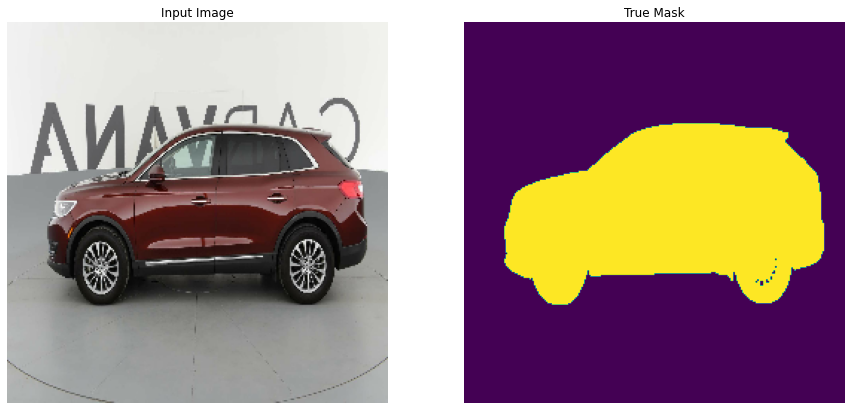

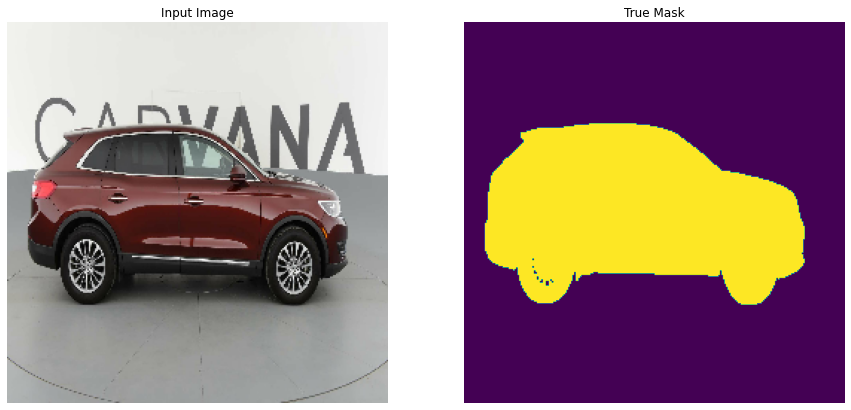

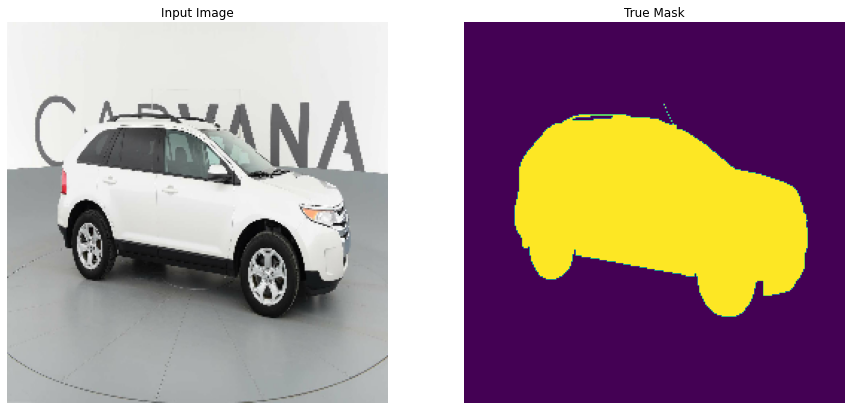

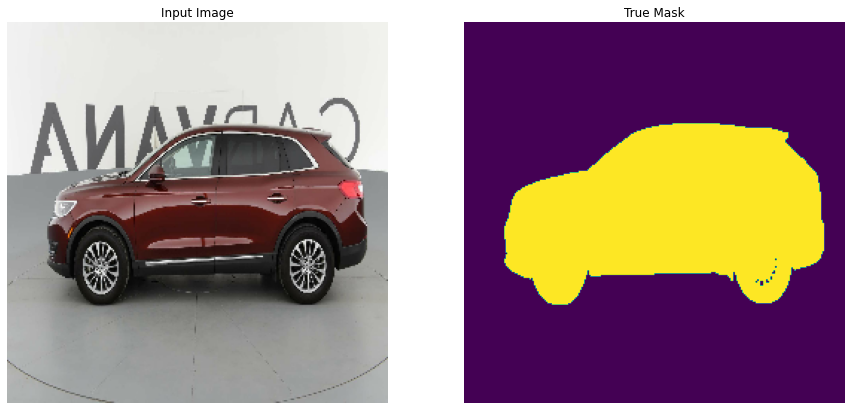

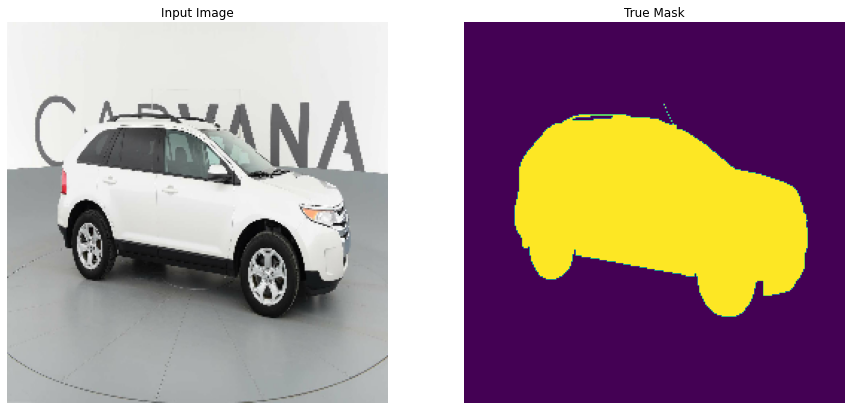

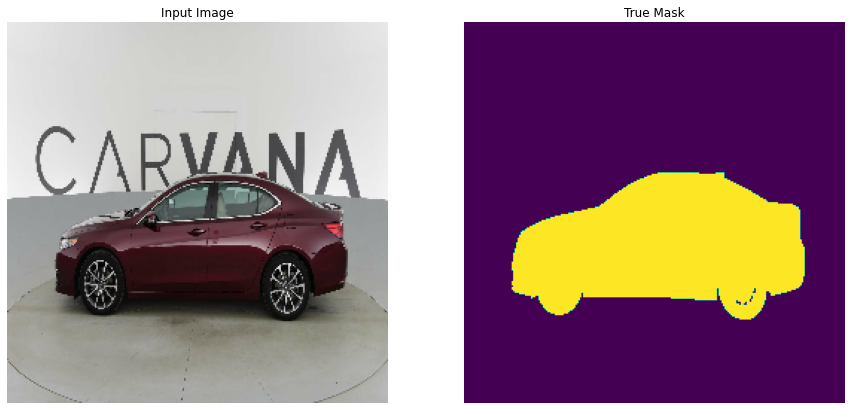

In [119]:
for i in range(4):
   a = 0
   for image, mask in train.take(i):
      sample_image, sample_mask = image, mask
      display([sample_image, sample_mask], f'examples{a}')
      a += 1

# U-Net Model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [15]:
# MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [16]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [19]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

[Model metrics.]('https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2')

We are going to use Dice Coefficient (F1 Score) to validate our model.

In [35]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 9  1841984     ['input_3[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

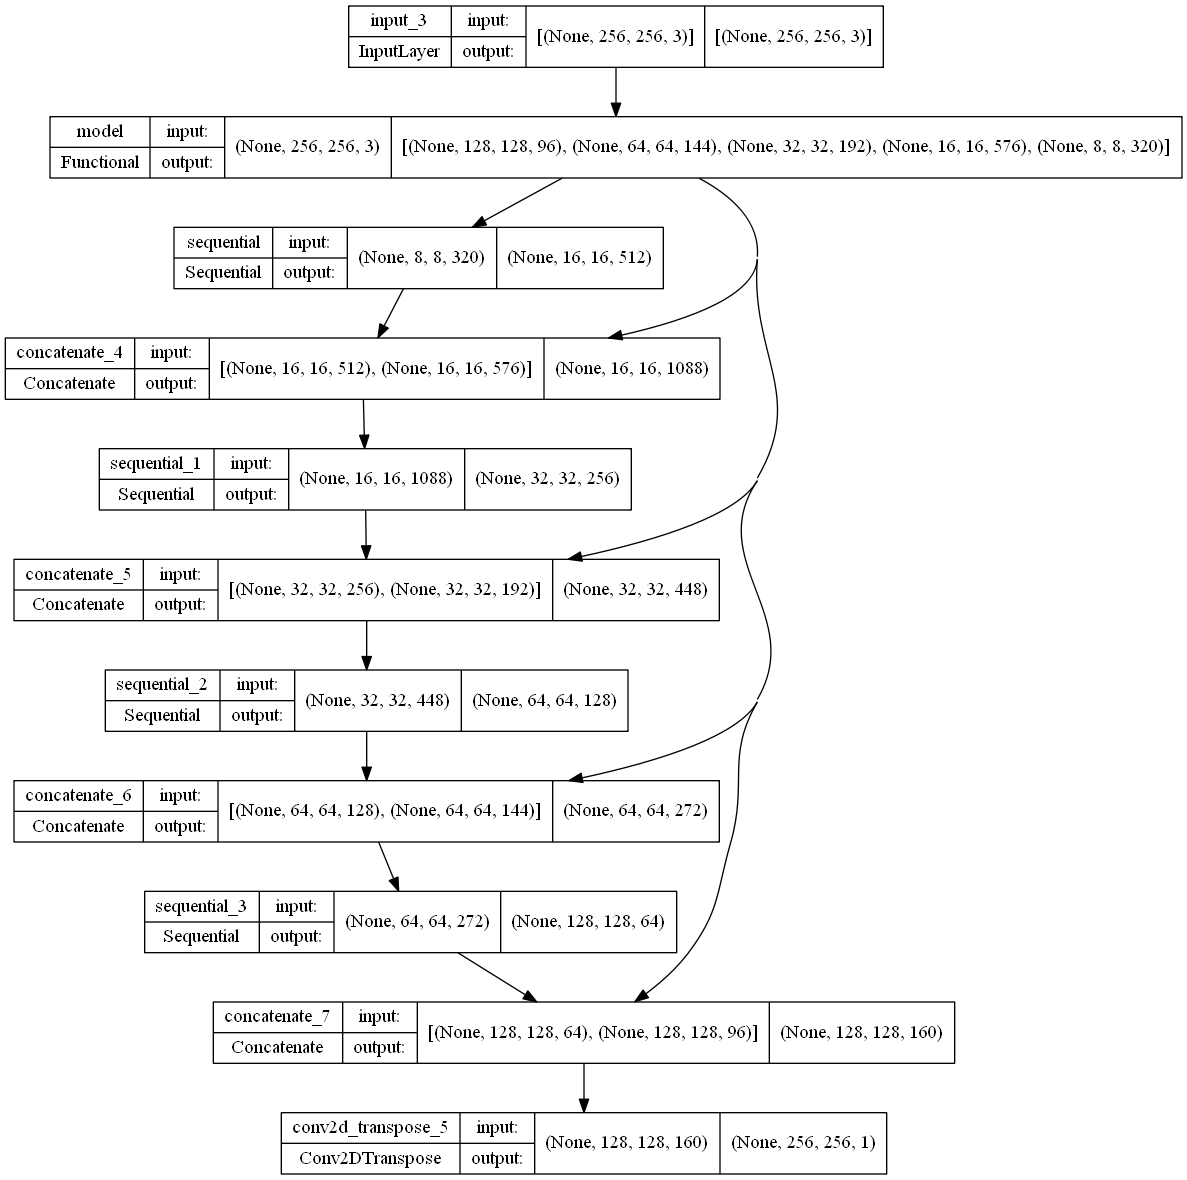

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Segmentation before Training

Let's try out the model to see what it predicts before training.

In [38]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [39]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

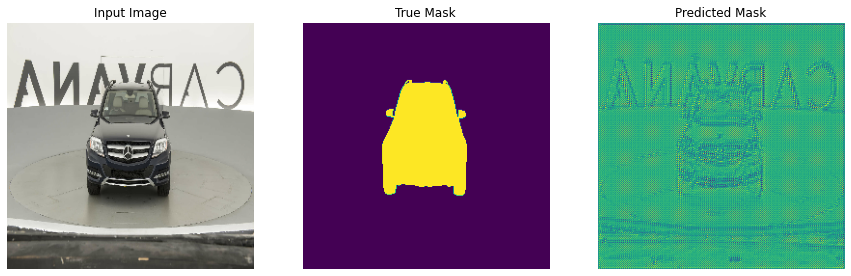

In [40]:
show_predictions(sample_image, sample_mask)

## Segmentation - Training for 15 Epochs

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)

## Train Model

Epoch 1/3
238/238 [==============================] - 596s 2s/step - loss: 0.0844 - dice_coef: 0.9156 - binary_accuracy: 0.9582 - val_loss: 0.0997 - val_dice_coef: 0.9003 - val_binary_accuracy: 0.9805
Epoch 2/3
238/238 [==============================] - 603s 3s/step - loss: 0.0187 - dice_coef: 0.9813 - binary_accuracy: 0.9934 - val_loss: 0.0251 - val_dice_coef: 0.9749 - val_binary_accuracy: 0.9925


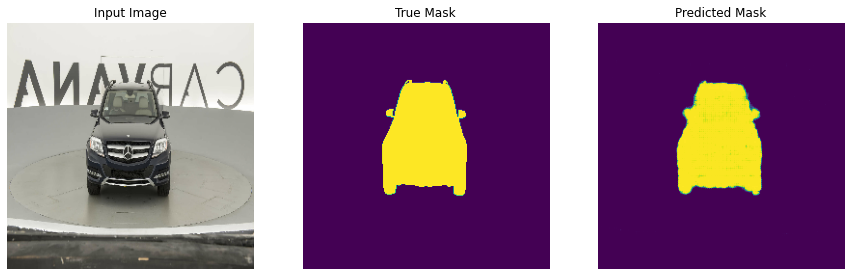

Epoch 3/3
238/238 [==============================] - 628s 3s/step - loss: 0.0153 - dice_coef: 0.9847 - binary_accuracy: 0.9943 - val_loss: 0.0155 - val_dice_coef: 0.9845 - val_binary_accuracy: 0.9941


In [42]:
EPOCHS = 3
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

### View Learning Curves

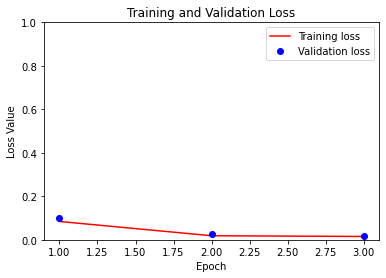

In [43]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = EPOCHS
epochs_rng = range(1,epochs+1)
plt.figure()
plt.plot(epochs_rng, loss, 'r', label='Training loss')
plt.plot(epochs_rng, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Make predictions on Sample Test Data

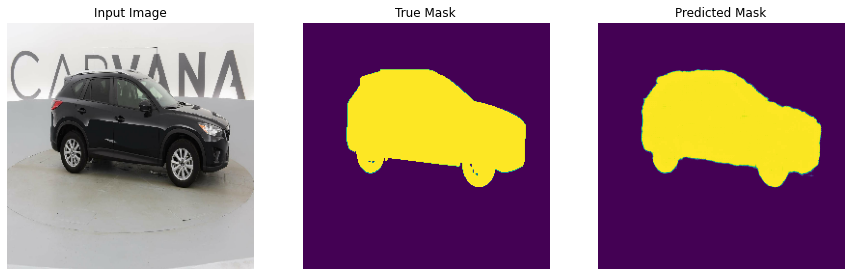

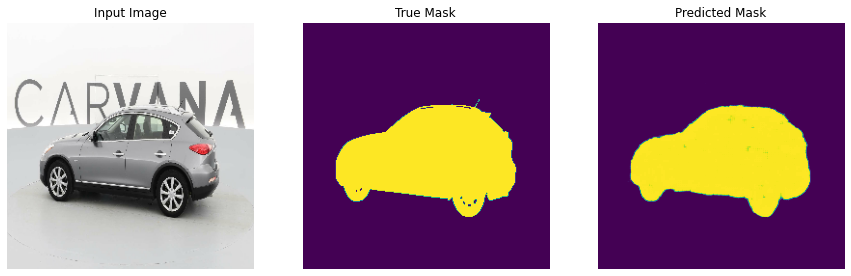

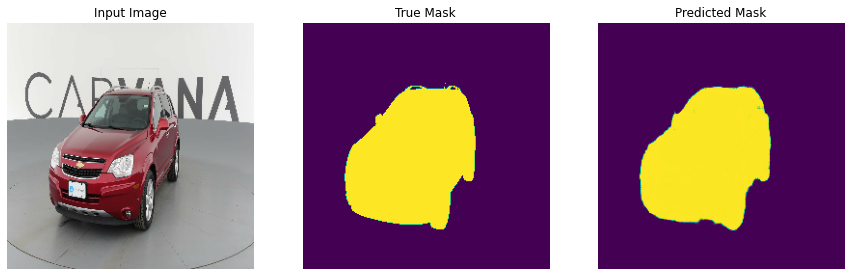

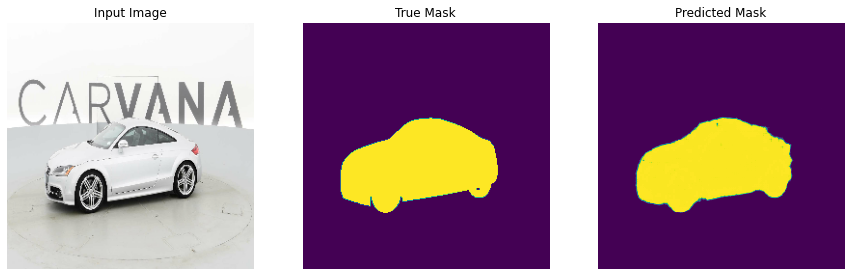

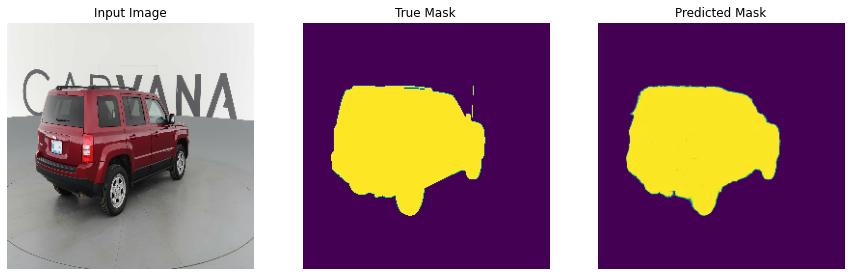

In [111]:
def show_predictions2(dataset, num, save=''):
    if save!='':
            a = 0
            
    for sample_image, sample_mask in dataset.take(num):
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
        display([sample_image, sample_mask, pred_mask], save + str(a))
        if save!='':
            a +=1

show_predictions2(valid, 5, save="predictions")
